# Gaussian Mixture Models GMM clustering

In Depth: Gaussian Mixture Models (Jake vanderPlas, Python Data Science Handbook)

Note that the "GMM" used in vanderPlas is no longer current.  The new module is sklearn.mixture.GaussianMixture, and it is slightly different. I tried to run vanderPlas' code and followed the error messages; in most cases the names of variables had changed slightly ("covariances_" rather than "covars", etc.) and were easy to fix by consulting the main page of scikitlearn:

https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [2]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

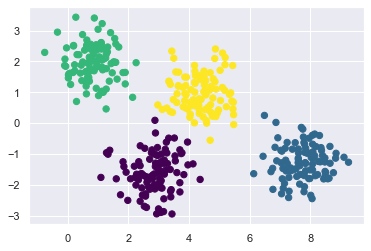

In [3]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

"From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assigment of points between them. Unfortunately, the k-means model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty). For this, we must think about generalizing the model.

One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster. We can visualize this cluster model with the following function:"  (vanderPlas)

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()  # radius = maximum distance of a pt in cluster vs. center
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

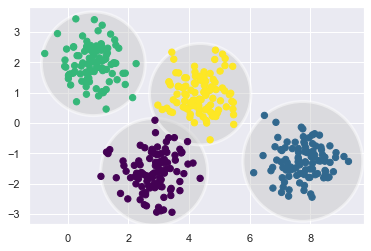

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

In [7]:
# note for k-means, clusters are presumed to be circular (since we are using distances)
# doesnt always work well depending on structure of the data)

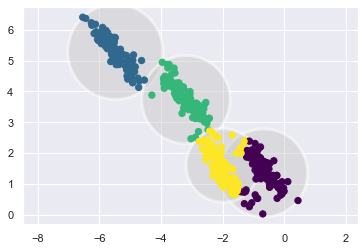

In [6]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))     # stretch and rotate the data

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

"A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means:" (vanderPlas)

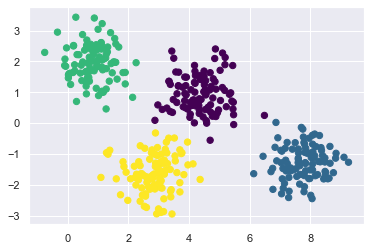

In [7]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

"But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the predict_proba method. This returns a matrix of size [n_samples, n_clusters] which measures the probability that any point belongs to the given cluster:" (vanderPlas)

In [41]:
probs = gmm.predict_proba(X)
print(probs[:10].round(3))

[[0.    0.    0.463 0.537]
 [0.    1.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    1.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.013 0.    0.987]
 [0.    1.    0.    0.   ]
 [1.    0.    0.    0.   ]]


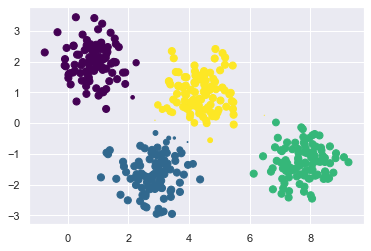

In [43]:
# use size of dot to visualize probability assignment
# note features near boundaries
size = 50 * probs.max(1)**10  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

"Under the hood, a Gaussian mixture model is very similar to k-means: it uses an expectation–maximization approach which qualitatively does the following:

Choose starting guesses for the location and shape

Repeat until converged:

1. E-step: for each point, find weights encoding the probability of membership in each cluster
2. M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model. Just as in the k-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

Let's create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:" (vanderPlas)

In [8]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).fit_predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

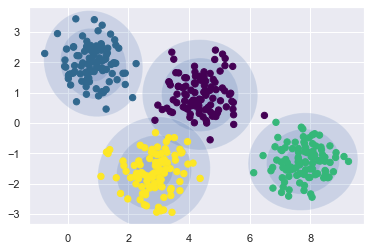

In [9]:
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X)

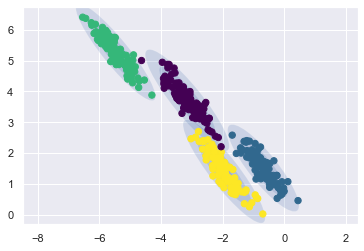

In [10]:
# now try with the stretched dataset
# covariance_type = 'full' means arbitrary ellipsoid
#                 = "diag" aligned with the coordinate axes
#                 = 'spherical' same in all directions (like k-means, but probabilistic)
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

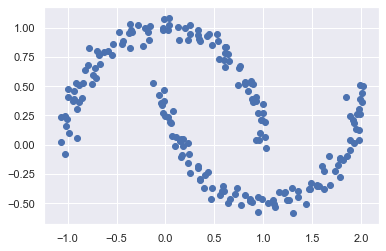

In [11]:
# can be used to make a "generative model" of data
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

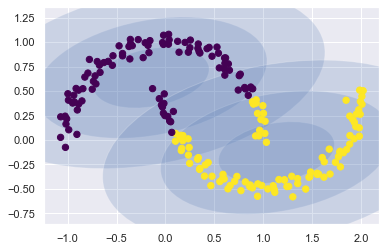

In [12]:
# stil doesn't work that well
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

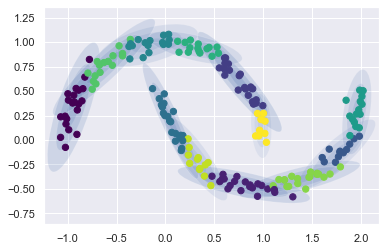

In [13]:
# but if we use more components we can fit the entire probability distribution as a superposition of Gaussian ellipses

gmm16 = GMM(n_components=12, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon)

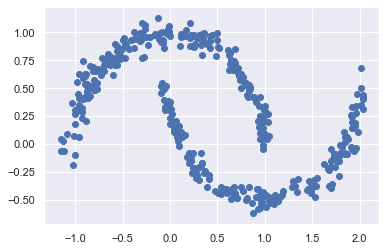

In [14]:
# "GENERATIVE MODEL" means we can use it to produce more!
# now given this distribution/fit to the data we are given, we can produce more
Xnew, ynew = gmm16.sample(n_samples=400)

plt.scatter(Xnew[:, 0], Xnew[:, 1])

"How many components?

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset. A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the likelihood of the data under the model, using cross-validation to avoid over-fitting. Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the Akaike information criterion (AIC) or the Bayesian information criterion (BIC). Scikit-Learn's GMM estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

Let's look at the AIC and BIC as a function as the number of GMM components for our moon dataset:" vanderPlas

The AIC can be termed as a mesaure of the goodness of fit of any estimated statistical model. The BIC is a type of model selection among a class of parametric models with different numbers of parameters.

When comparing the Bayesian Information Criteria and the Akaike’s Information Criteria, penalty for additional parameters is more in BIC than AIC. Unlike the AIC, the BIC penalizes free parameters more strongly.


Read more: Difference Between AIC and BIC | Difference Between http://www.differencebetween.net/miscellaneous/difference-between-aic-and-bic/#ixzz7KQk6jCas

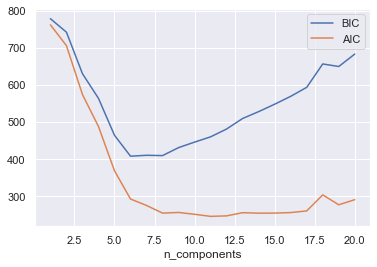

In [15]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

# back to digits

In [16]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

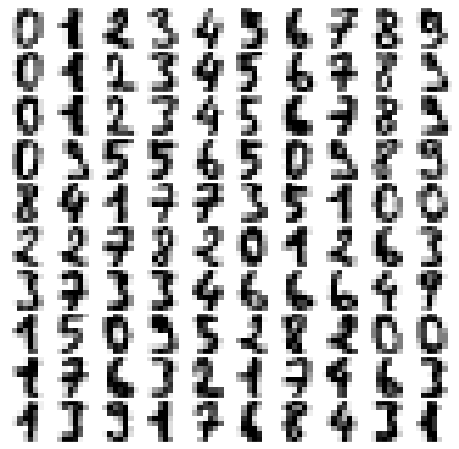

In [17]:
#plot the first 100
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

In [18]:
# to reduce dimensionality: use PCA to retain 99% of variance
from sklearn.decomposition import PCA
pca = PCA(0.95, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 29)

In [36]:
# so, 29 dimensions (out of 64 raw)

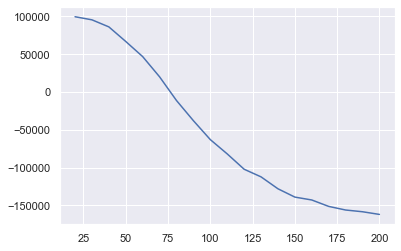

In [19]:
# use AIC to figure out how many GMM components
n_components = np.arange(20, 210, 10)
models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

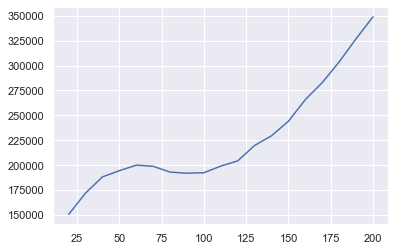

In [20]:
# use BIC to figure out how many GMM components
n_components = np.arange(20, 210, 10)
models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]
bics = [model.fit(data).bic(data) for model in models]
plt.plot(n_components, bics);

In [21]:
# check convergence
gmm = GMM(20, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [22]:
# now make 100 new samples (in the space of the 41 best PCs)
data_new, y_data_new = gmm.sample(n_samples=100)
data_new.shape

(100, 29)

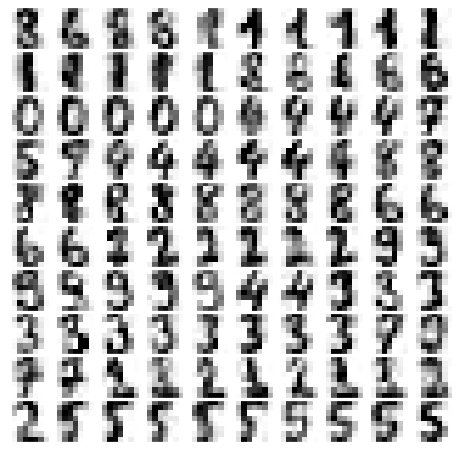

In [97]:
# now invert PCA!
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)